### Инструкции

Для выполнения этого задания вам понадобятся данные о среднемесячных уровнях заработной платы в России:

WAG_C_M.csv
В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, здесь http://sophist.hse.ru/exes/tables/WAG_M.htm  



Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

### Review criteria 
Придерживайтесь стандартного алгоритма построения прогноза:

Визуальный анализ ряда<br>
Стабилизация дисперсии (при необходимости)<br>
Выбор порядка дифференцирования<br>
Выбор начальных приближений для p,q,P,Q<br>
Обучение и сравнение моделей-кандидатов, выбор победителя<br>
Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.<br>
Прогнозирование с помощью финальной модели

In [16]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [17]:
path=r"C:\Users\Волочков\PycharmProjects\FiztehML\6Course"
data = pd.read_csv(path+r'\WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head(3)

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6


In [18]:
#обратное преобразование Бокса Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

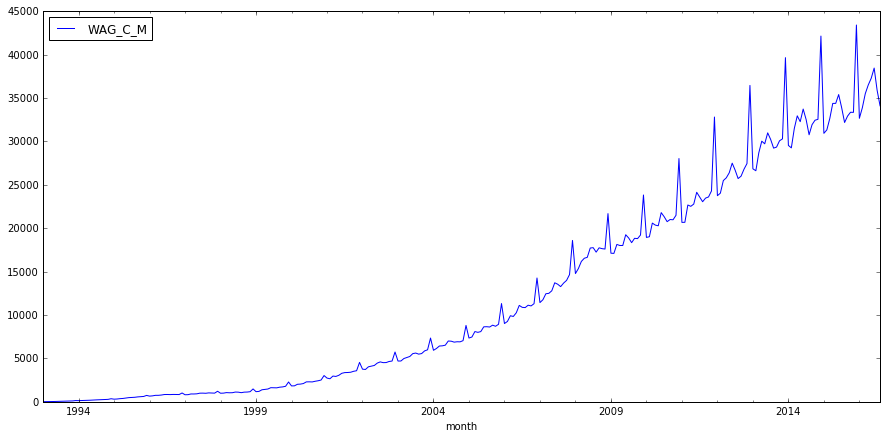

In [19]:
plt.figure(figsize(15,7))
data.plot()
#plt.ylabel(u'')
#plt.title('')
pylab.show()

Критерий Дики-Фуллера: p=0.991850


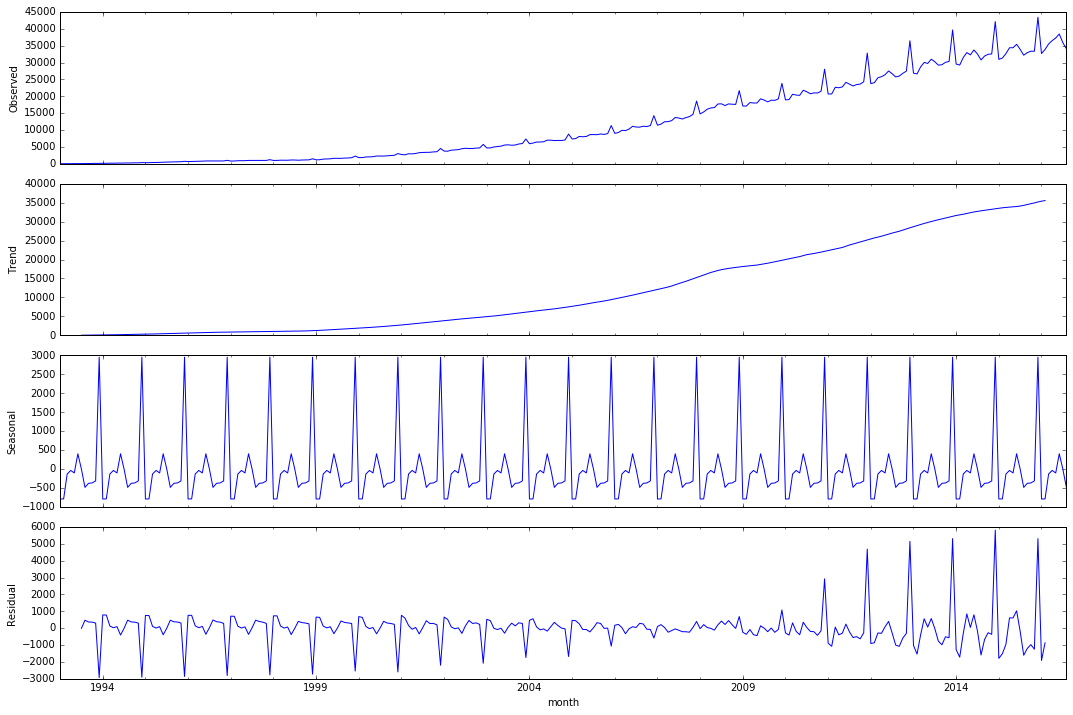

In [20]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

Явно выражен тренд, сезонность , расширяющаяся дисперсия.

#### Стабилизация 

In [21]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)
"Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda

'Оптимальный параметр преобразования Бокса-Кокса: 0.263202'

#### Дифференцирование
Избавляемся от тренда

In [22]:
data['WAG_C_M_box_diff'] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff.dropna())[1])

Критерий Дики-Фуллера: p=0.014697


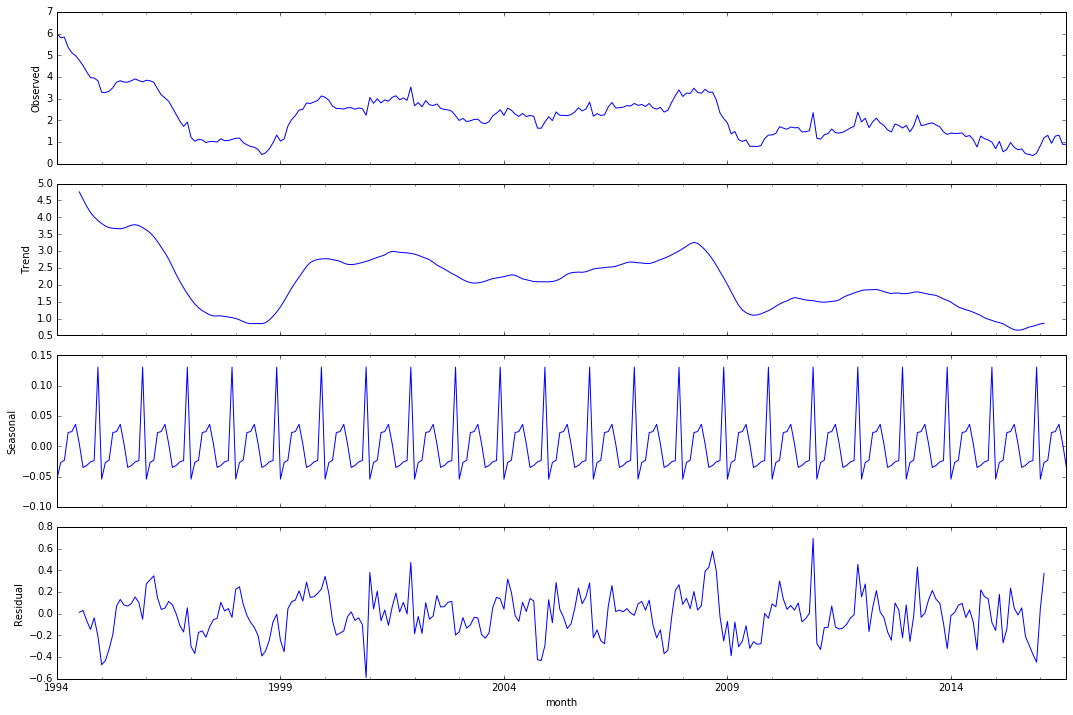

In [23]:
#Нулевая гипотеза о нестационарности отвергается по критерию Дики-Фуллера.
#Построим графики,для того чтобы в этом убедиться
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff.dropna()).plot()   
pylab.show()

Критерий Дики-Фуллера: p=0.000000


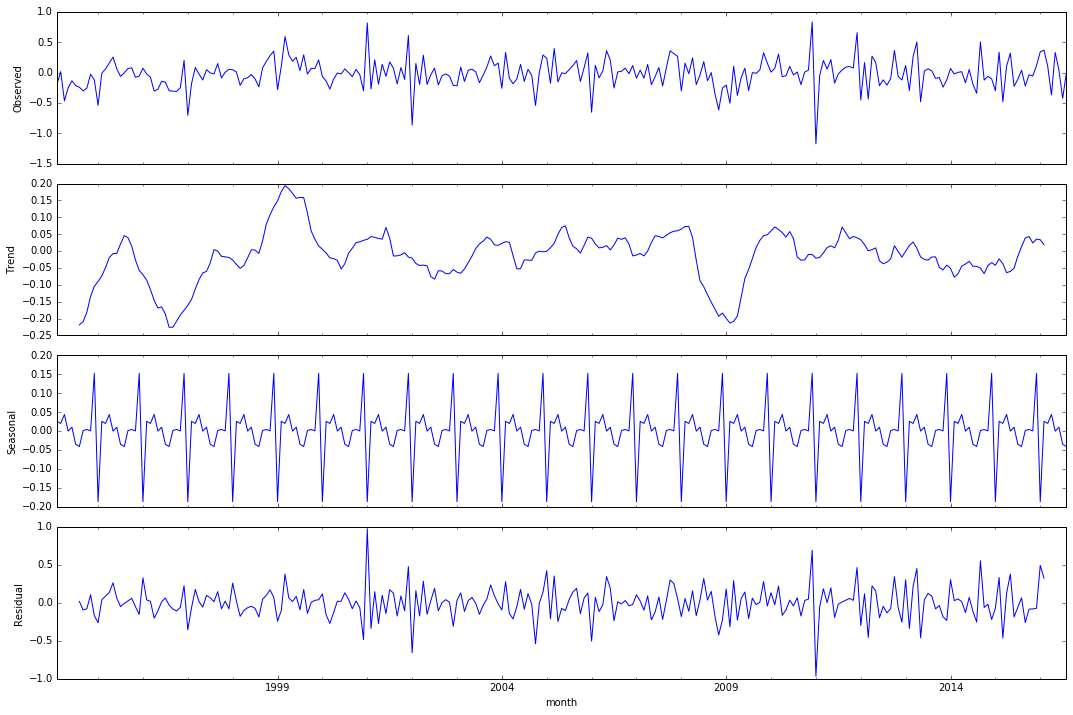

In [24]:
#Тренд остался нестационарен, продифференцируем еще раз

data['WAG_C_M_box_diff2'] = data.WAG_C_M_box_diff - data.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff2.dropna()).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff2.dropna())[1])

Критерий Дики-Фуллера: p=0.000000


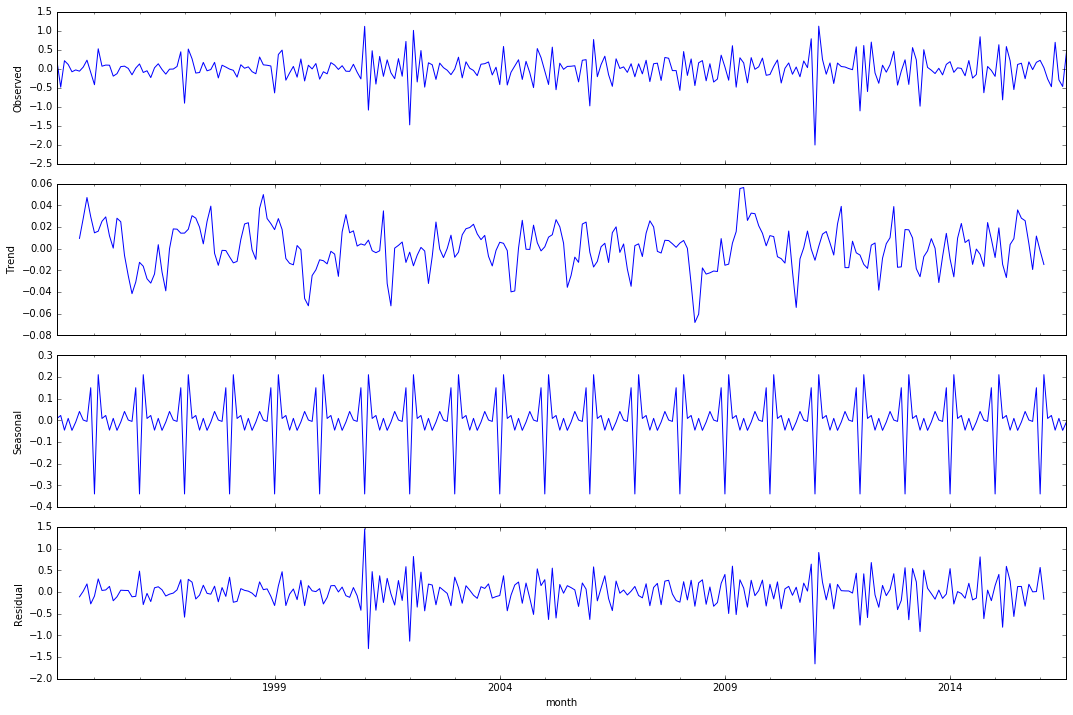

In [29]:
#дифференцируем еще раз
data['WAG_C_M_box_diff3'] = data.WAG_C_M_box_diff2 - data.WAG_C_M_box_diff2.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff3.dropna()).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff3.dropna())[1])

### Подбор модели
Посмотрим на ACF и PACF полученного ряда:

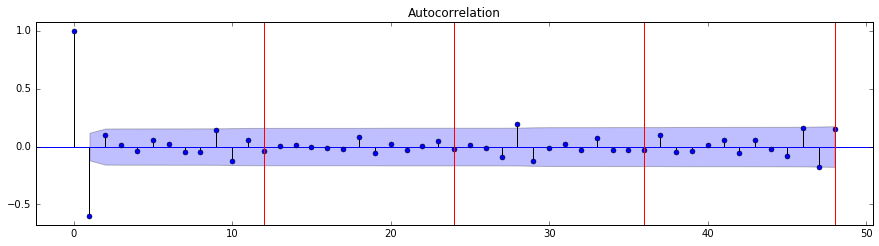

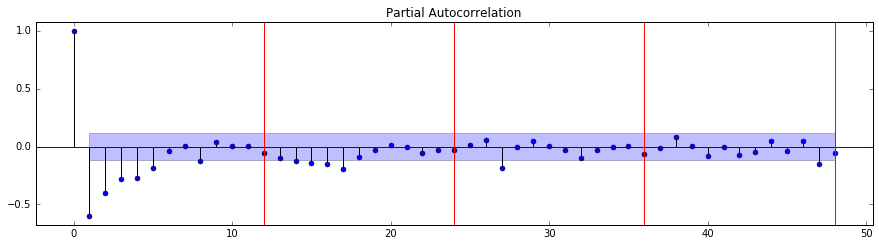

In [36]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_C_M_box_diff3.dropna().values.squeeze(), lags=48, ax=ax)
for i in range(12, 60, 12):
    plt.axvline(i, -0.3, 1, c='r')
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_box_diff3.dropna().values.squeeze(), lags=48, ax=ax)
for i in range(12, 60, 12):
    plt.axvline(i, -0.3, 1, c='r')
pylab.show()

Значимо отличается от нуля на ACF точка 28 ,число несезонных компонент-0
на PACF -26 

Начальные приближения: Q=3, q=0, P=3, p=6

In [54]:
ps = range(0, 7)
d=2 # тк 2 раза дифференциорал
qs = range(0, 1)
Ps = range(0, 4)
D=1 # одно сезонное дифференцирование
Qs = range(0,4)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

112

In [55]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
Wall time: 9min 52s


In [56]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters       aic
88   (5, 0, 2, 1)  4.322853
104  (6, 0, 2, 1)  4.904935
90   (5, 0, 2, 3)  5.686119
108  (6, 0, 3, 1)  6.015653
106  (6, 0, 2, 3)  6.040809


In [58]:
#Лучшая модель:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(5, 2, 0)x(2, 1, 1, 12)   Log Likelihood                   6.839
Date:                            Tue, 11 Oct 2016   AIC                              4.323
Time:                                    15:45:49   BIC                             37.164
Sample:                                01-01-1993   HQIC                            17.489
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1139      0.048    -23.303      0.000      -1.208      -1.020
ar.L2         -0.9941      0.073   

Критерий Стьюдента: p=0.863004
Критерий Дики-Фуллера: p=0.000000


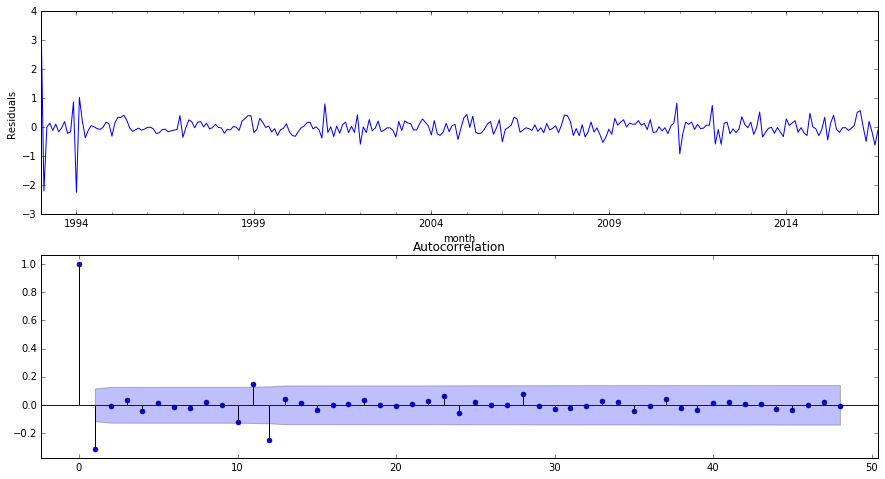

In [62]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.dropna().plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.dropna().values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid.dropna(), 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid.dropna())[1])

In [65]:
q_test = sm.tsa.stattools.acf(model.resid.dropna(), qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]})
#из чего видим что остатки случайны

,Q-stat,p-value
0,26.710185,2.363723e-07
1,26.724071,1.573772e-06
2,27.238537,5.246930e-06
3,27.714729,1.424836e-05
4,27.756444,4.061396e-05
5,27.811053,1.019815e-04
6,28.319806,1.923980e-04
7,28.565280,3.778812e-04
8,28.567969,7.661739e-04
9,33.050903,2.670721e-04


Из критерия Стьюдента мы не можем утверждать, что остатки смещены. По графику видно, что они скорей всего не смещены.
Остатки стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

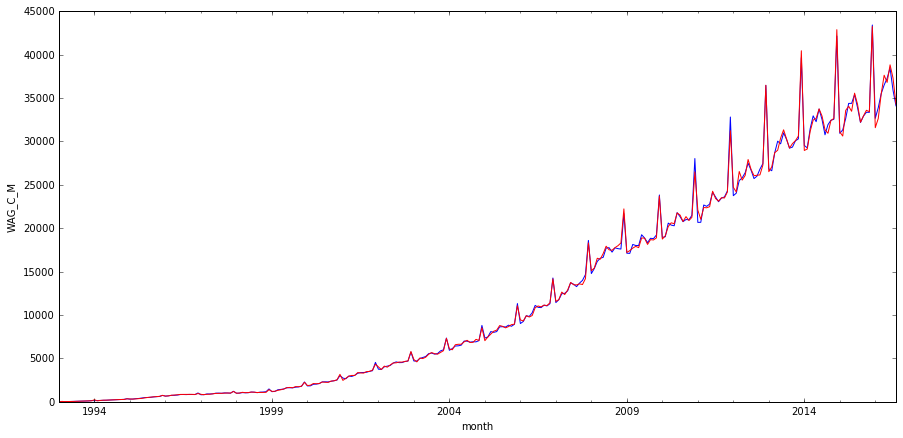

In [64]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model.dropna().plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()

### Прогноз

In [94]:
data2 = data[['WAG_C_M']]
date_list = [max(data2.index) + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=data.shape[0], end=data2.shape[0]), lmbda)

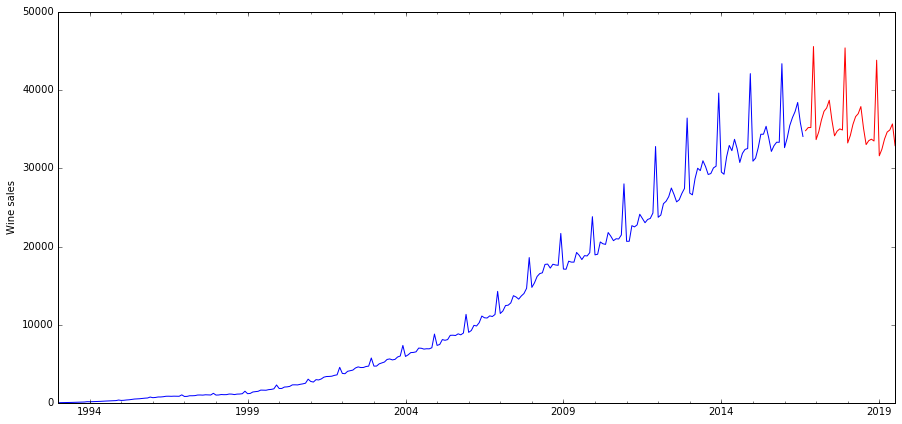

In [95]:
plt.figure(figsize(15,7))
data2.WAG_C_M.dropna().plot()
data2.forecast.dropna().plot(color='r')
plt.ylabel('Wine sales')
pylab.show()